# Sheet 6
Integrantes: Felipe Mendoza Navarrete, Sofía Macias Pérez y Mariana Ramirez Gomez.

## Exercise 1:

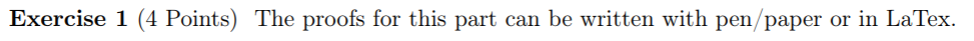

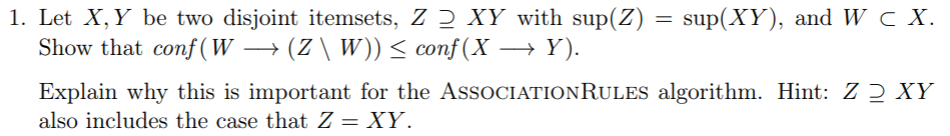

Podemos expresar la confianza de la regla $conf(W\rightarrow (Z|W))$ como:

$$conf(W\rightarrow (Z|W)) = \frac{sup(W) \cup (Z/W)}{sup(W) } $$

Dado que $Z\supseteq XY$ y $W \supseteq X$, podemos decir que $W \cup (Z/W) = Z$ porque Z contiene todos los elementos en $X$ y $Y$ y $W$ es un subconjunto de $X$. Así que:

$$sup(W\cup (Z/W))=sup(Z)$$

Teniendo en cuenta que $sup(Z)=sup(XY)$ entonces podemos escribir la confianza como:
$$conf(W\rightarrow (Z|W)) = \frac{sup(Z)}{sup(W)} = \frac{sup(XY)}{sup(W)}$$

Dado que $W\subset X$, entonces $sup(W)\le sup(X)$. Asi que podemos concluir que

$$\frac{sup(XY)}{sup(W)}\le \frac{sup(XY)}{sup(X)}$$

Este resultado es importante porque muestra que reducir la premisa de una regla no incrementa la confianza de la regla. Esto es clave para la generación de reglas de asociación pues asegura que se consideren unicamente las reglas más relevantes.

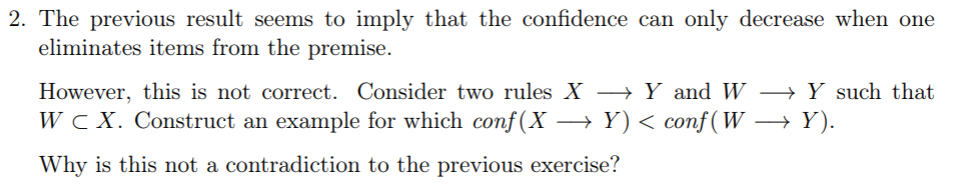

- Transacción 1 = {A,B,C}
- Transacción 2 = {A,B}
- Transacción 3 = {A,C}
- Transacción 4 = {B,C}

Los itemset son:
- X = {A,B}
- Y = {C}
- W = {A}

$$conf(X\rightarrow Y)= \frac{sup(XY)}{sup(X)} = \frac{1}{2}$$
$$conf(W\rightarrow Y)= \frac{sup(WY)}{sup(W)} = \frac{2}{3}$$

De este modo, tenemos:
$$conf(X\rightarrow Y) < conf(W\rightarrow Y)$$

Esto no es una contradicción debido a que estamos considerando directamente el itemset $Y$ y no el complemento de $W$ en $Z$. Esto es importante para entender cómo se comporta la confianza en reglas de asociación, permitiendo diseñar algoritmos más eficientes.

## Exercise 2:

### 2.1:

In [1]:
import pandas as pd

def eclat(db, minsup):
    # Create a vertical database of items with their transaction IDs
    def vertical_representation(db):
        item_tidset = {}
        for tid, transaction in enumerate(db):
            for item in set(transaction):  # avoid duplicates in each transaction
                if item not in item_tidset:
                    item_tidset[item] = set()
                item_tidset[item].add(tid)
        return item_tidset
    
    # Recursive subfunction to compute frequent itemsets
    def recursive_eclat(prefix, items, minsup, frequent_itemsets):
        while items:
            item, tidset = items.pop()
            support = len(tidset)
            if support >= minsup:
                # Add frequent itemset
                frequent_itemsets.append((set(prefix + [item]), support))
                # Find subsets of this frequent itemset
                suffix = []
                for other_item, other_tidset in items:
                    new_tidset = tidset & other_tidset
                    if len(new_tidset) >= minsup:
                        suffix.append((other_item, new_tidset))
                # Recursively find frequent itemsets
                recursive_eclat(prefix + [item], suffix, minsup, frequent_itemsets)
    
    # Step 1: Convert the database into vertical representation
    item_tidset = vertical_representation(db)
    
    # Step 2: Run ECLAT recursively to find frequent itemsets
    frequent_itemsets = []
    recursive_eclat([], list(item_tidset.items()), minsup, frequent_itemsets)
    
    # Return frequent itemsets as a Pandas DataFrame
    result_df = pd.DataFrame(frequent_itemsets, columns=["Itemset", "Support"])
    
    return result_df

### 2.2:

In [2]:
from itertools import chain, combinations

def getStrongRulesFromFrequentSets(fsets, minconf):
    strong_rules = []
    
    # Function to compute subsets of an itemset
    def get_subsets(itemset):
        return chain.from_iterable(combinations(itemset, r) for r in range(1, len(itemset)))
    
    for itemset, support in fsets:
        for premise in get_subsets(itemset):
            premise_set = set(premise)
            conclusion_set = itemset - premise_set
            if conclusion_set:
                # Compute support of premise
                premise_support = next((sup for items, sup in fsets if items == premise_set), 0)
                # Compute confidence
                confidence = support / premise_support if premise_support > 0 else 0
                if confidence >= minconf:
                    strong_rules.append((premise_set, conclusion_set, support, confidence))
    
    # Return strong rules as a Pandas DataFrame
    rules_df = pd.DataFrame(strong_rules, columns=["Premise", "Conclusion", "Support", "Confidence"])
    return rules_df

def getStrongRulesForDatabase(db, minsup, minconf):
    # Step 1: Compute frequent itemsets using the eclat algorithm
    frequent_itemsets_df = eclat(db, minsup)
    fsets = [tuple(x) for x in frequent_itemsets_df.to_numpy()]
    
    # Step 2: Compute strong rules from frequent itemsets
    strong_rules_df = getStrongRulesFromFrequentSets(fsets, minconf)
    
    return strong_rules_df

### 2.3:

In [3]:
def read_shop_data(file_path):
    db = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip leading/trailing spaces and split by whitespace or commas
            transaction = line.strip().split()
            # Convert transaction into a list of items (strings or numbers)
            db.append(transaction)
    return db

# File path to the uploaded shop.dat file
file_path = 'datasets/shop.dat'

# Read the shop data into a list of transactions
db = read_shop_data(file_path)

# Minimum confidence and support thresholds
minconf = 0.75
minsup = 500

# Compute strong rules
strong_rules_df = getStrongRulesForDatabase(db, minsup, minconf)

# Sort the strong_rules_df by the 'Support' column in descending order
sorted_strong_rules_df = strong_rules_df.sort_values(by='Support', ascending=False)

# Filter strong rules where the conclusion contains at least two items
filtered_rules_df = strong_rules_df[strong_rules_df['Conclusion'].apply(lambda x: len(x) >= 2)]

# Create a new column for the length of conclusions
filtered_rules_df['ConclusionLength'] = filtered_rules_df['Conclusion'].apply(len)

# Sort by support and number of items in conclusion
sorted_filtered_rules_df = filtered_rules_df.sort_values(by=['Support', 'ConclusionLength'], ascending=[False, False])

# Report
print("Strong Rules (Support >= 500, Confidence >= 0.75):")
print(sorted_strong_rules_df)
print("\nFiltered Strong Rules (Conclusion with at least 2 items):")
print(sorted_filtered_rules_df)

Strong Rules (Support >= 500, Confidence >= 0.75):
             Premise  Conclusion  Support  Confidence
963        {825, 39}       {704}     1035    0.871946
962        {704, 39}       {825}     1035    0.934959
961       {704, 825}        {39}     1035    0.939201
450       {390, 722}       {227}      907    0.870441
449       {390, 227}       {722}      907    0.864633
..               ...         ...      ...         ...
95        {815, 105}  {862, 494}      500    0.811688
96        {105, 862}  {815, 494}      500    0.811688
97   {815, 862, 494}       {105}      500    0.915751
98   {815, 105, 494}       {862}      500    0.905797
100  {815, 105, 862}       {494}      500    0.914077

[964 rows x 4 columns]

Filtered Strong Rules (Conclusion with at least 2 items):
        Premise  Conclusion  Support  Confidence  ConclusionLength
264  {515, 283}  {346, 217}      773    0.925749                 2
265  {283, 346}  {515, 217}      773    0.849451                 2
266  {283, 217}  

/var/folders/4l/3kt45bp907g_zjx6qwp8r7v00000gn/T/ipykernel_26275/2194892483.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules_df['ConclusionLength'] = filtered_rules_df['Conclusion'].apply(len)


#### Meaning first's rules:
- Strong Rules (Support >= 500, Confidence >= 0.75): The first rule states that when items 39 and 825 are purchased together (the premise), it is very likely that item 704 will also be purchased (the conclusion).The support of 1035 means that the combination of items {39, 825, 704} appears in 1035 transactions in the dataset. The confidence of 0.871946 (or approximately 87%) means that in 87% of the transactions where items 39 and 825 were bought together, item 704 was also bought.

- Filtered Strong Rules (Conclusion with at least 2 items): The first rule states that when items 283 and 515 are purchased together (the premise), it is very likely that items 346 and 217 (the conclusion) will also be purchased together. The support of 773 means that the combination of items {515, 217, 283, 346} appears in 773 transactions in the dataset. The confidence of 0.925749 (or approximately 92.6%) means that in 92.6% of the transactions where items 283 and 515 were bought together, items 217 and 346 were also bought.
